### ***Deep Learning for Channel Coding via Neural Mutual Information Estimation***





This code sets up and trains an autoencoder for 16-QAM communication systems using deep learning.

- It defines the autoencoder's architecture and functionality, including encoding, adding noise, and decoding. It also includes a neural network for estimating mutual information, which is used to optimize the autoencoder's performance.

- The training process involves multiple epochs and steps, adjusting the encoder, decoder, and mutual information estimator through gradient-based optimization. Finally, the code tests the autoencoder's performance by evaluating its bit error rate across a range of signal-to-noise ratios, providing insights into its effectiveness under different conditions.

In [15]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from scipy import special
from tensorflow import keras
import matplotlib.pyplot as plt
assert sys.version_info >= (3, 5)


# ------------------------------------ Set random seeds for reproducibility ------------------------------------
np.random.seed(42)
tf.random.set_seed(42)

### **This class defines an AutoEncoder for communication systems with optional Rayleigh fading channel simulation.**

- It includes:
    - Encoder: Maps input symbols to a latent space representation.

    - Channel: Simulates noise effects with optional Rayleigh fading.

    - Decoder: Maps the latent space representation back to symbol space.

    
- Methods:
    - __init__: Initializes the AutoEncoder with parameters for modulation order, channel conditions, and more.

    - EbNo_to_noise: Converts `Eb/N0 (dB)` to noise standard deviation.
    - sample_Rayleigh_channel: Simulates a Rayleigh fading channel and adds noise to the signal.

    - random_sample: Generates random input symbols.

    - B_Ber_m: Computes the Batch `Bit Error Rate (BBER)` between input and decoded messages.

    - test_encoding: Visualizes the encoding space by plotting the encoded symbols.

In [16]:
class AutoEncoder:
    def __init__(self, M=16, n=1, training_snr=7, rayleigh=False):
        self.M = M
        self.k = int(np.log2(M))
        self.n = n
        self.training_snr = training_snr
        self.rayleigh = rayleigh
        self.noise_std = self.EbNo_to_noise(training_snr)

        # Define custom layers
        self.norm_layer = keras.layers.Lambda(lambda x: tf.divide(x, tf.sqrt(2 * tf.reduce_mean(tf.square(x)))))
        self.shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1, 2, n]))
        self.shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1, 2 * n]))
        self.channel_layer = keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=self.noise_std))

        # Define the encoder model
        self.encoder = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal'),
            keras.layers.Dense(M, activation="elu"),
            keras.layers.Dense(2 * n, activation=None),
            self.shape_layer,
            self.norm_layer
        ])

        # Define the channel model
        if rayleigh:
            self.channel = keras.models.Sequential([keras.layers.Lambda(lambda x: self.sample_Rayleigh_channel(x, self.noise_std))])
        else:
            self.channel = keras.models.Sequential([self.channel_layer])

        # Define the decoder model
        self.decoder = keras.models.Sequential([
            keras.layers.InputLayer(input_shape=[2, n]),  # استفاده از shape به جای input_shape
            self.shape_layer2,
            keras.layers.Dense(M, activation="elu"),
            keras.layers.Dense(M, activation="softmax")
        ])

        # Combine encoder, channel, and decoder into an autoencoder model
        self.autoencoder = keras.models.Sequential([self.encoder, self.channel, self.decoder])

    def EbNo_to_noise(self, ebnodb):
        '''Transform EbNo[dB]/snr to noise power'''
        ebno = 10**(ebnodb/10)
        noise_std = 1/np.sqrt(2*(self.k/self.n)*ebno)
        return noise_std

    def sample_Rayleigh_channel(self, x, noise_std):
        h_sample = (1/np.sqrt(2)) * tf.sqrt(tf.random.normal(tf.shape(x))**2 + tf.random.normal(tf.shape(x))**2)
        z_sample = tf.random.normal(tf.shape(x), stddev=noise_std)
        y_sample = x + tf.divide(z_sample, h_sample)
        return tf.cast(y_sample, tf.float32)

    def random_sample(self, batch_size=32):
        msg = np.random.randint(self.M, size=(batch_size, 1))
        return msg

    def B_Ber_m(self, input_msg, msg):
        '''Calculate the Batch Bit Error Rate'''
        batch_size = input_msg.shape[0]
        pred_error = tf.not_equal(tf.reshape(input_msg, shape=(-1, batch_size)), tf.argmax(msg, 1))
        bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
        return bber

    def test_encoding(self):
        inp = np.arange(0, self.M)
        coding = self.encoder.predict(inp)
        fig = plt.figure(figsize=(4,4))
        plt.plot(coding[:,0], coding[:, 1], "b.")
        plt.xlabel("$x_1$", fontsize=18)
        plt.ylabel("$x_2$", fontsize=18, rotation=0)
        plt.grid(True)
        plt.gca().set_ylim(-2, 2)
        plt.gca().set_xlim(-2, 2)
        plt.show()

### **This class defines a neural network model for computing pairwise scores between input pairs.**

It is used to estimate mutual information by evaluating how similar pairs of inputs are.

- Methods:
    - __init__: Initializes the neural network with a specified number of hidden layers, neurons, and activation functions.
    - **call**: Computes pairwise scores for inputs x and y. It creates a matrix of input pairs, passes them through the network, and returns the score matrix.

In [17]:
class NNFunction(tf.keras.Model):
    def __init__(self, hidden_dim, layers, activation, **extra_kwargs):
        super(NNFunction, self).__init__()
        self._f = tf.keras.Sequential(
            [tf.keras.layers.Dense(hidden_dim, activation) for _ in range(layers)] +
            [tf.keras.layers.Dense(1)]
        )

    def call(self, x, y):
        batch_size = tf.shape(x)[0]
        x_tiled = tf.tile(x[None, :], (batch_size, 1, 1))
        y_tiled = tf.tile(y[:, None], (1, batch_size, 1))
        xy_pairs = tf.reshape(tf.concat((x_tiled, y_tiled), axis=2), [batch_size * batch_size, -1])
        scores = self._f(xy_pairs)
        return tf.transpose(tf.reshape(scores, [batch_size, batch_size]))

### **A class to facilitate the training of an autoencoder model with additional functionalities for mutual information estimation and decoder training.**

This class provides methods to:

  1. Train the mutual information `(MI)` neural estimator `(MINE)` to estimate the mutual information between the encoded and received signals.

  2. Train the decoder of the autoencoder using sparse categorical crossentropy loss.

  3. Train the encoder of the autoencoder while simultaneously estimating mutual information.

  4. Evaluate the performance of the autoencoder by calculating `Bit Error Rate (BER)` across a range of `Signal-to-Noise Ratios (SNRs)`.

- Attributes:
  - **autoencoder** :  An instance of the AutoEncoder class, which includes the encoder, decoder, and possibly a channel model.

  - **nn_function** : An instance of a neural network model used for estimating mutual information between encoded and received signals.

  - **loss_fn** : A loss function, specifically SparseCategoricalCrossentropy, used for training the decoder.

  - **mean_loss** : A metric used to track and compute the average loss during training.

In [18]:
class Trainer:
    def __init__(self, autoencoder, nn_function):
        """
            Initialize a trainer for training an autoencoder with mutual information neural estimator (MINE).
        """
        self.autoencoder = autoencoder
        self.nn_function = nn_function
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        self.mean_loss = tf.keras.metrics.Mean()

    def MINE(self, scores):
        """
            Calculate the mutual information (MI) using the Mutual Information Neural Estimator (MINE) method.
        """
        def marg(x):
            batch_size = x.shape[0]
            marg_ = tf.reduce_mean(tf.exp(x - tf.linalg.tensor_diag(np.inf * tf.ones(batch_size))))
            return marg_ * ((batch_size * batch_size) / (batch_size * (batch_size - 1.)))
        joint_term = tf.reduce_mean(tf.linalg.diag_part(scores))                                                            # Calculate the mean of diagonal elements of scores
        marg_term = marg(scores)                                                                                            # Calculate the marginal term using the defined function `marg`
        return joint_term - tf.math.log(marg_term)                                                                          # Return the MI estimation based on MINE

    def plot_loss(self, step, epoch, mean_loss, X_batch, y_pred, plot_encoding):
        """
            Print and optionally plot loss and Batch Bit Error Rate (BER).
        """
        template = 'Iteration: {}, Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
        if step % 10 == 0:
            print(template.format(step, epoch, mean_loss.result(), self.autoencoder.B_Ber_m(X_batch, y_pred)))
            if plot_encoding:
                self.autoencoder.test_encoding()

    def plot_batch_loss(self, epoch, mean_loss, X_batch, y_pred):
        """
            Print interim results of loss and Batch Bit Error Rate (BER).
        """
        template_outer_loop = 'Interim result for Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
        print(template_outer_loop.format(epoch, mean_loss.result(), self.autoencoder.B_Ber_m(X_batch, y_pred)))

    def train_mi(self, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005):
        """
            Train the neural network using mutual information (MI) estimation.
        """
        optimizer_mi = tf.keras.optimizers.Nadam(learning_rate=learning_rate)                                               # Initialize Nadam optimizer for MI estimation
        for epoch in range(1, n_epochs + 1):
            print("Training in Epoch {}/{}".format(epoch, n_epochs))
            for step in range(1, n_steps + 1):
                X_batch = self.autoencoder.random_sample(batch_size)                                                        # Generate random input batch
                with tf.GradientTape() as tape:
                    x_enc = self.autoencoder.encoder(X_batch, training=True)                                                # Encode input batch
                    y_recv = self.autoencoder.channel(x_enc)                                                                # Simulate channel
                    x = tf.reshape(x_enc, shape=[batch_size, 2 * self.autoencoder.n])                                       # Reshape encoded input
                    y = tf.reshape(y_recv, shape=[batch_size, 2 * self.autoencoder.n])                                      # Reshape received signal
                    score = self.nn_function(x, y)                                                                          # Compute score using neural network function
                    loss = -self.MINE(score)                                                                                # Calculate loss using MINE estimator
                    gradients = tape.gradient(loss, self.nn_function.trainable_variables)                                   # Compute gradients
                    optimizer_mi.apply_gradients(zip(gradients, self.nn_function.trainable_variables))                      # Apply gradients

                mi_avg = -self.mean_loss(loss)                                                                              # Calculate average mutual information
            print('Epoch: {}, Mi is {}'.format(epoch, mi_avg))
            self.mean_loss.reset_state()                                                                                   # Reset mean_loss metric


    def train_decoder(self, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005, plot_encoding=True):
        """
            Train the autoencoder's decoder.
        """
        optimizer_ae = tf.keras.optimizers.Nadam(learning_rate=learning_rate)                                               # Initialize Nadam optimizer for decoder training
        for epoch in range(1, n_epochs + 1):
            print("Training Decoder in Epoch {}/{}".format(epoch, n_epochs))
            for step in range(1, n_steps + 1):
                X_batch = self.autoencoder.random_sample(batch_size)                                                        # Generate random input batch
                with tf.GradientTape() as tape:
                    y_pred = self.autoencoder.autoencoder(X_batch, training=True)                                           # Perform autoencoder forward pass
                    loss = tf.reduce_mean(self.loss_fn(X_batch, y_pred))                                                    # Calculate loss using sparse categorical crossentropy
                    gradients = tape.gradient(loss, self.autoencoder.decoder.trainable_variables)                           # Compute gradients
                    optimizer_ae.apply_gradients(zip(gradients, self.autoencoder.decoder.trainable_variables))              # Apply gradients
                self.mean_loss(loss)                                                                                        # Update mean_loss metric
                self.plot_loss(step, epoch, self.mean_loss, X_batch, y_pred, plot_encoding)                                 # Plot loss and possibly encoding
            self.plot_batch_loss(epoch, self.mean_loss, X_batch, y_pred)                                                    # Plot batch loss
            self.mean_loss.reset_state()                                                                                   # Reset mean_loss metric


    def train_encoder(self, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.05):
        """
            Train the autoencoder's encoder and estimate mutual information (MI).
        """
        optimizer_mi = tf.keras.optimizers.Nadam(learning_rate=0.005)                                                       # Initialize Nadam optimizer for MI estimation
        optimizer_ae = tf.keras.optimizers.Nadam(learning_rate=learning_rate)                                               # Initialize Nadam optimizer for autoencoder encoder
        for epoch in range(1, n_epochs + 1):
            print("Training Encoder in Epoch {}/{}".format(epoch, n_epochs))
            for step in range(1, n_steps + 1):
                X_batch = self.autoencoder.random_sample(batch_size)                                                        # Generate random input batch
                with tf.GradientTape() as tape:
                    x_enc = self.autoencoder.encoder(X_batch, training=True)                                                # Encode input batch
                    y_recv = tf.identity(self.autoencoder.channel(x_enc))                                                   # Simulate channel with gradient pass-through
                    x = tf.reshape(x_enc, shape=[batch_size, 2 * self.autoencoder.n])                                       # Reshape encoded input
                    y = tf.reshape(y_recv, shape=[batch_size, 2 * self.autoencoder.n])                                      # Reshape received signal
                    score = self.nn_function(x, y)                                                                          # Compute score using neural network function
                    loss = -self.MINE(score)                                                                                # Calculate loss using MINE estimator
                    gradients = tape.gradient(loss, self.autoencoder.encoder.trainable_variables)                           # Compute gradients
                    optimizer_ae.apply_gradients(zip(gradients, self.autoencoder.encoder.trainable_variables))              # Apply gradients
                mi_avg = -self.mean_loss(loss)                                                                              # Calculate average mutual information
            with tf.GradientTape() as tape:
                X_batch = self.autoencoder.random_sample(batch_size)                                                        # Generate random input batch
                x_enc = self.autoencoder.encoder(X_batch, training=True)                                                    # Encode input batch
                y_recv = self.autoencoder.channel(x_enc)                                                                    # Simulate channel
                x = tf.reshape(x_enc, shape=[batch_size, 2 * self.autoencoder.n])                                           # Reshape encoded input
                y = tf.reshape(y_recv, shape=[batch_size, 2 * self.autoencoder.n])                                          # Reshape received signal
                score = self.nn_function(x, y)                                                                              # Compute score using neural network function
                loss = -self.MINE(score)                                                                                    # Calculate loss using MINE estimator
                gradients = tape.gradient(loss, self.nn_function.trainable_variables)                                       # Compute gradients
                optimizer_mi.apply_gradients(zip(gradients, self.nn_function.trainable_variables))                          # Apply gradients
            print('Epoch: {}, Mi is {}'.format(epoch, mi_avg))


    def Test_AE(self):
        """
            Evaluate the autoencoder's performance by calculating Bit Error Rate (BER) for varying Signal-to-Noise Ratios (SNRs).
        """
        snr_range = np.linspace(0, 15, 31)                                                                                  # Create a range of SNRs
        bber_vec = [None] * len(snr_range)                                                                                  # Initialize a list to store BER values
        for db in range(len(snr_range)):                                                                                    # Loop over each SNR value
            for it in range(1, 1000):                                                                                       # Perform multiple iterations for each SNR
                noise_std = self.autoencoder.EbNo_to_noise(snr_range[db])                                                   # Calculate noise standard deviation
                X_batch = self.autoencoder.random_sample(500)                                                               # Generate random input batch
                code_word = self.autoencoder.encoder(X_batch)                                                               # Encode input batch
                if self.autoencoder.rayleigh:
                    rcvd_word = self.autoencoder.sample_Rayleigh_channel(code_word, noise_std)                              # Apply Rayleigh fading channel
                else:
                    rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)               # Add Gaussian noise
                dcoded_msg = self.autoencoder.decoder(rcvd_word)                                                            # Decode received word
                bber = self.autoencoder.B_Ber_m(X_batch, dcoded_msg)                                                        # Calculate Bit Error Rate (BER)
                bber_avg = self.mean_loss(bber)                                                                             # Calculate average BER
            bber_vec[db] = bber_avg                                                                                         # Store average BER for current SNR
            self.mean_loss.reset_state()                                                                                    # Reset mean_loss metric
            if (db % 6 == 0) & (db > 0):                                                                                    # Print progress every 6 parts
                print(f'Progress: {db} of {30} parts')
        return (snr_range, bber_vec)


Training in Epoch 1/1
Epoch: 1, Mi is 1.4977705478668213
Training Encoder in Epoch 1/5
Epoch: 1, Mi is 1.5448893308639526
Training Encoder in Epoch 2/5
Epoch: 2, Mi is 1.4811832904815674
Training Encoder in Epoch 3/5
Epoch: 3, Mi is 1.4765141010284424
Training Encoder in Epoch 4/5
Epoch: 4, Mi is 1.4826922416687012
Training Encoder in Epoch 5/5
Epoch: 5, Mi is 1.469829797744751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


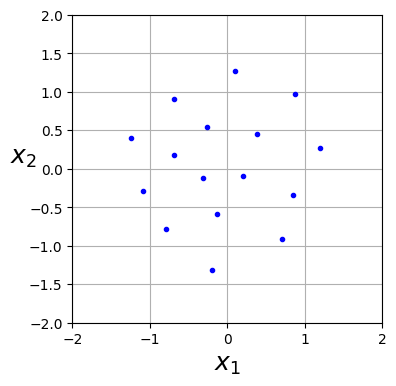

Training Decoder in Epoch 1/5
Iteration: 10, Epoch: 1, Loss: -1.44865, Batch_BER: 0.91200
Iteration: 20, Epoch: 1, Loss: -1.42844, Batch_BER: 0.80200
Iteration: 30, Epoch: 1, Loss: -1.40917, Batch_BER: 0.75800
Iteration: 40, Epoch: 1, Loss: -1.39081, Batch_BER: 0.68400
Iteration: 50, Epoch: 1, Loss: -1.37339, Batch_BER: 0.69200
Iteration: 60, Epoch: 1, Loss: -1.35681, Batch_BER: 0.63800
Iteration: 70, Epoch: 1, Loss: -1.34098, Batch_BER: 0.57200
Iteration: 80, Epoch: 1, Loss: -1.32577, Batch_BER: 0.46200
Iteration: 90, Epoch: 1, Loss: -1.31112, Batch_BER: 0.43000
Iteration: 100, Epoch: 1, Loss: -1.29704, Batch_BER: 0.43600
Iteration: 110, Epoch: 1, Loss: -1.28316, Batch_BER: 0.42200
Iteration: 120, Epoch: 1, Loss: -1.26936, Batch_BER: 0.40400
Iteration: 130, Epoch: 1, Loss: -1.25638, Batch_BER: 0.31200
Iteration: 140, Epoch: 1, Loss: -1.24355, Batch_BER: 0.26800
Iteration: 150, Epoch: 1, Loss: -1.23104, Batch_BER: 0.28800
Iteration: 160, Epoch: 1, Loss: -1.21878, Batch_BER: 0.27600
Ite

In [19]:
# Initialize models and trainer
autoencoder = AutoEncoder(M=16, n=1, training_snr=7, rayleigh=True)
score_fn = NNFunction(layers=2, hidden_dim=256, activation='relu')

trainer = Trainer(autoencoder, score_fn)
trainer.train_mi(n_epochs=1, n_steps=500, batch_size=64)
trainer.train_encoder(n_epochs=5, n_steps=400, batch_size=64, learning_rate=0.005)
trainer.autoencoder.test_encoding()
trainer.train_decoder(n_epochs=5, n_steps=400, batch_size=500, learning_rate=0.005, plot_encoding=False)
bber_data = trainer.Test_AE()

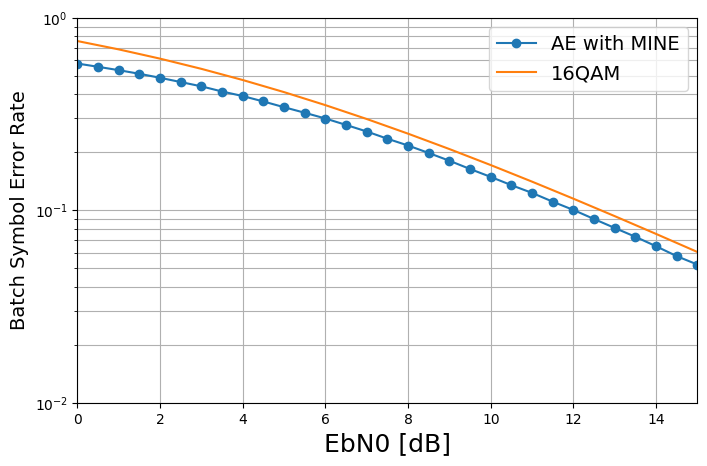

In [20]:
# Approximate 16 QAM Error
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

def MQAM_rayleigh_approx(M, ebnodb):
    ebno = 10.**(ebnodb/10)
    esno = 4*ebno
    a=3.25
    b=3/(M-1)
    e=b*esno
    return (a/2)*(1-np.sqrt(0.5*e / (1+0.5*e) ) ), a/(2*b*esno)

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(bber_data[0], bber_data[1], 'o-')
a, b = MQAM_rayleigh_approx(16,ebnodbs)
plt.plot(ebnodbs, a);
plt.gca().set_ylim(1e-2, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("EbN0 [dB]", fontsize=18)
plt.legend(['AE with MINE', '16QAM'], prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")